In [1]:
from pathlib import Path
import os, json

CONFIG = "dataset_config.json"

def save_config(root):
    with open(CONFIG, "w") as f:
        json.dump({"dataset_root": str(root)}, f)

def repo_root():
    cwd = Path.cwd().resolve()
    if (cwd / "data").exists():
        return cwd
    if cwd.name == "main_code" and (cwd.parent / "data").exists():
        return cwd.parent.resolve()
    return cwd

def find_jpeg_dir(root):
    root = Path(root)
    for r, dirs, _ in os.walk(root):
        if "JPEGImages" in dirs:
            return Path(r) / "JPEGImages"
    return None

def ensure_dataset():
    base = repo_root() / "data" / "processed"
    candidates = [
        base / "PASCAL_VOC" / "PASCAL_VOC",
        base / "PASCAL_VOC",
        base
    ]
    json_names = {"pascal_train2007.json", "pascal_val2007.json", "pascal_test2007.json"}
    for target in candidates:
        if target.is_dir():
            json_ok = all((target / j).exists() for j in json_names)
            if json_ok or find_jpeg_dir(target):
                save_config(target)
                print("Using dataset under:", target)
                return target
    raise RuntimeError("Dataset not found. Expected under one of: " + ", ".join(str(c) for c in candidates))

dataset_root = Path(ensure_dataset())

Using dataset under: C:\Users\giaco\Desktop\Projects\PASCAL_VOC_2007\data\processed\PASCAL_VOC\PASCAL_VOC


In [ ]:
# Relative paths: we use JSONs in data/processed/PASCAL_VOC/PASCAL_VOC (train/val/test)
import os
import json
from pathlib import Path

json_dir = dataset_root
json_dir_str = str(json_dir)
processed_root = json_dir.parent.parent  # go up to data/processed to find VOCtrainval/VOCtest
train_json = json_dir / "pascal_train2007.json"
val_json = json_dir / "pascal_val2007.json"
test_json = json_dir / "pascal_test2007.json"

trainval_jpeg_dir = processed_root / "VOCtrainval_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"
test_jpeg_dir = processed_root / "VOCtest_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"

with open(train_json, "r") as f:
    data = json.load(f)

def candidate_image_paths(fname):
    # use declared paths directly, without recursive search
    return [
        trainval_jpeg_dir / fname,
        test_jpeg_dir / fname,
    ]

# Inspect content
print("Keys in the JSON file:", data.keys())
# keys are: images, type, annotations, categories

# Inspect first 5 images
print("First 5 images:", data['images'][:5])
# Inspect first 5 annotations
print("First 5 annotations:", data['annotations'][:5])
# Inspect categories
print("Categories:", data['categories'])
# Inspect dataset type
print("Type of dataset:", data['type'])

# Visualize 3 images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_image(image_id):
    image_info = next(img for img in data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == ann['category_id'])
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

Keys in the JSON file: dict_keys(['images', 'type', 'annotations', 'categories'])
First 5 images: [{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
First 5 annotations: [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[

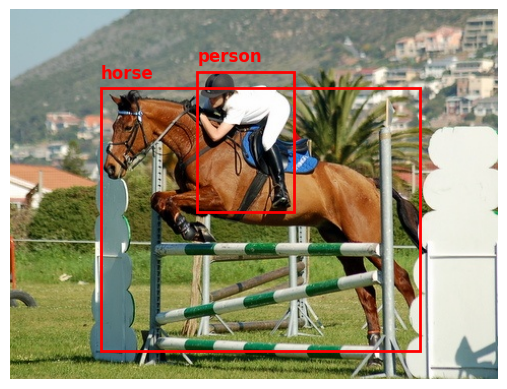

In [4]:
visualize_image(17)

In [ ]:
# so now we have a dataset and we want to create a CNN to train on it and recognize objects in images

import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            # (3, 32) means: 3 input channels (RGB), 32 output filters (feature maps).
            # The filter is 3x3 because kernel_size=3.
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 112x112
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 56x56
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Output: 28x28
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        # Input features: 128 (from last conv block)
        self.classifier = nn.Sequential(
            nn.Linear(128, 512),
            nn.LeakyReLU(0.1),
            # NOTE: We do not put Sigmoid here because we use BCEWithLogitsLoss
            # which includes sigmoid internally for numerical stability.
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

num_classes = len(data['categories'])
model = CNN(num_classes)
# Change: Use BCEWithLogitsLoss for multi-label classification (multi-object)
# This loss expects unnormalized LOGITS, not probabilities.
criterion = nn.BCEWithLogitsLoss()
# Slightly increase learning rate or keep standard, but add weight decay
optimizer = optim.Adam(model.parameters(), lr=0.025, weight_decay=1e-4)

# now we need to train it on the dataset
# but first we need to create a DataLoader for the dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PascalVOCDataset(Dataset):
    def __init__(self, data, root, transform=None, num_classes=20):
        self.data = data
        self.root = root
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        image_info = self.data['images'][idx]
        fname = image_info['file_name']

        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Change: The target becomes a presence vector (multi-hot encoding)
        label = torch.zeros(self.num_classes, dtype=torch.float32)
        annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == image_info['id']]
        
        for ann in annotations:
            # Assuming category_id starts from 1
            cat_idx = ann['category_id'] - 1
            if 0 <= cat_idx < self.num_classes:
                label[cat_idx] = 1.0

        return image, label

from torchvision import transforms

# We add Data Augmentation to make the model more robust
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet Normalization
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PascalVOCDataset(data, dataset_root, transform=transform_train, num_classes=num_classes)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Prepare Validation DataLoader
# Load validation dataset here to use it during training
with open(val_json, 'r') as f:
    val_data = json.load(f)
val_dataset = PascalVOCDataset(val_data, dataset_root, transform=transform_val, num_classes=num_classes)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
import torch
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
    print("device count:", torch.cuda.device_count())

torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True
device name: NVIDIA GeForce RTX 3060 Laptop GPU
device count: 1


In [ ]:
# training loop
from tqdm.notebook import tqdm
import torch # Ensure torch is imported if needed, though usually available
import numpy as np

num_epochs = 15
# Lists to save history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [], # (TP + TN) / Total
    'val_precision': [], # TP / (TP + FP)
    'val_recall': [], # TP / (TP + FN)
    'val_f1': [] # 2 * (P * R) / (P + R)
}

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

model.to(device)

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    total_batches = len(dataloader)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = running_loss / total_batches
    history['train_loss'].append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    val_running_loss = 0.0
    val_tp, val_tn, val_fp, val_fn = 0, 0, 0, 0
    total_val_batches = len(val_dataloader)
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Metric calculation
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            
            # Element-wise stats
            val_tp += (predicted * labels).sum().item()
            val_tn += ((1 - predicted) * (1 - labels)).sum().item()
            val_fp += (predicted * (1 - labels)).sum().item()
            val_fn += ((1 - predicted) * labels).sum().item()
            
    avg_val_loss = val_running_loss / total_val_batches
    history['val_loss'].append(avg_val_loss)
    
    # Calculate aggregate metrics
    epsilon = 1e-7
    accuracy = (val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn + epsilon)
    precision = val_tp / (val_tp + val_fp + epsilon)
    recall = val_tp / (val_tp + val_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    
    history['val_accuracy'].append(accuracy)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    history['val_f1'].append(f1)
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {accuracy:.4f} | "
          f"Val F1: {f1:.4f} | "
          f"LR: {current_lr:.6f}")

# save the trained model
torch.save(model.state_dict(), "cnn_pascalvoc.pth")
torch.save(history, "training_history.pth")

Training on device: cuda
Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Epoch 1/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 10.7363 | Val Loss: 1.1759 | Val Acc: 0.9132 | Val F1: 0.3200 | LR: 0.250000


Epoch 2/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/15 | Train Loss: 0.3845 | Val Loss: 8.9574 | Val Acc: 0.9224 | Val F1: 0.0000 | LR: 0.250000


Epoch 3/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/15 | Train Loss: 0.2641 | Val Loss: 2.6582 | Val Acc: 0.9224 | Val F1: 0.0000 | LR: 0.250000


Epoch 4/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

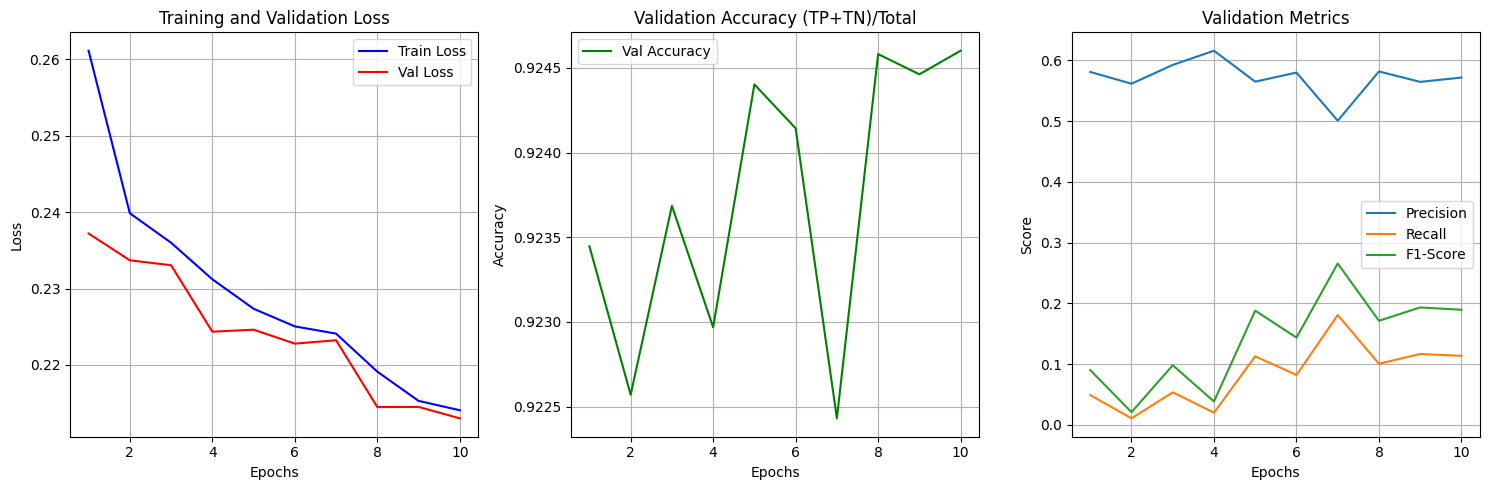

In [10]:
# Plotting Training History
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_accuracy'], 'g-', label='Val Accuracy')
    plt.title('Validation Accuracy (TP+TN)/Total')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot Precision/Recall/F1
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1'], label='F1-Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [12]:
# Detailed Evaluation on Validation Set
# (This can also be done on 'test_json' if you want final results)

# Re-use existing val_dataloader or creating test_dataloader
# eval_loader = val_dataloader 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

tp, tn, fp, fn = 0, 0, 0, 0
total_elements = 0   

print("Starting evaluation...")
with torch.no_grad():
    for images, labels in tqdm(val_dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        
        # Accumulate component-wise counts
        tp += (predicted * labels).sum().item()
        tn += ((1 - predicted) * (1 - labels)).sum().item()
        fp += (predicted * (1 - labels)).sum().item()
        fn += ((1 - predicted) * labels).sum().item()
        
        total_elements += labels.numel()

epsilon = 1e-7
accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
f1 = 2 * (precision * recall) / (precision + recall + epsilon)

print("--- Global Metrics (Element-wise) ---")
print(f"Accuracy:  {accuracy*100:.2f}%  (TP+TN / Total)")
print(f"Precision: {precision*100:.2f}% (TP / TP+FP) - 'Of what I predict True, how much is actually true?'")
print(f"Recall:    {recall*100:.2f}%    (TP / TP+FN) - 'How much of the total do I manage to find?'")
print(f"F1-Score:  {f1*100:.2f}%")

print("\n--- Component analysis ---")
print(f"True Positives: {int(tp)}")
print(f"True Negatives: {int(tn)}")
print(f"False Positives: {int(fp)}")
print(f"False Negatives: {int(fn)}")

Starting evaluation...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

--- Global Metrics (Element-wise) ---
Accuracy:  92.46%  (TP+TN / Total)
Precision: 57.18% (TP / TP+FP) - 'Of what I predict True, how much is actually true?'
Recall:    11.34%    (TP / TP+FN) - 'How much of the total do I manage to find?'
F1-Score:  18.93%

--- Component analysis ---
True Positives: 442
True Negatives: 45973
False Positives: 331
False Negatives: 3454


In [ ]:
# Visualize an image from the validation dataset with model predictions

# Ensure val_data is available (in case previous cells were skipped)
if 'val_data' not in locals() and 'val_data' not in globals():
    with open(val_json, 'r') as f:
        val_data = json.load(f)

def visualize_image_with_predictions(image_id):
    image_info = next(img for img in val_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Image {fname} not found. Tried paths: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    # Preprocess image using transform_val instead of undefined transform
    input_tensor = transform_val(Image.open(image_path).convert('RGB')).unsqueeze(0)

    # Move to same device as model
    input_tensor = input_tensor.to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs)[0] # Get probabilities for first image in batch

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis('off')

    # Get Ground Truth
    annotations = [ann for ann in val_data['annotations'] if ann['image_id'] == image_id]
    gt_category_ids = {ann['category_id'] for ann in annotations}
    gt_names = []
    for cat_id in gt_category_ids:
         cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
         if cat_info:
             gt_names.append(cat_info['name'])
    
    # Get Top Predictions
    predictions = []
    for i in range(num_classes):
        # Infer category ID. Assuming 1-based index corresponding to i+1
        score = probs[i].item()
        cat_id = i + 1 
        cat_info = next((cat for cat in val_data['categories'] if cat['id'] == cat_id), None)
        name = cat_info['name'] if cat_info else f"Unknown-{cat_id}"
        predictions.append((name, score))
    
    # Sort by score desc
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Display text
    title_text = f"Ground Truth: {', '.join(gt_names)}\n\nTop Predictions:"
    for name, score in predictions[:5]:
        title_text += f"\n{name}: {score:.4f}"
        
    plt.title(title_text, loc='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    plt.show()

# Pick a random image if no ID is specified
import random
random_image_id = random.choice(val_data['images'])['id']
visualize_image_with_predictions(random_image_id)

NameError: name 'eval_data' is not defined